In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine 

### Конфигурация для подключения к базе данных `data-analyst-advanced-sql`
Эта база данных содержит схему `stackoverflow`, с которой вы будете работать в проекте

In [2]:
db_config = {
    'user': 'praktikum_student', # имя пользователя
    'pwd': 'Sdf4$2;d-d30pp', # пароль
    'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
    'port': 6432, # порт подключения
    'db': 'data-analyst-advanced-sql' # название базы данных
}  

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

Создание подключения

In [3]:
engine = create_engine(connection_string) 

Пример запроса к базе данных

`sample_df` является pandas-датафреймом.

In [4]:
query = '''
SELECT *
FROM stackoverflow.users
LIMIT 10;
'''

sample_df = pd.read_sql_query(query, con=engine) 

In [5]:
sample_df

,id,creation_date,display_name,last_access_date,location,reputation,views
0,1,2008-07-31 14:22:31,Jeff Atwood,2018-08-29 02:34:23,"El Cerrito, CA",44300,408587
1,2,2008-07-31 14:22:31,Geoff Dalgas,2018-08-23 17:31:56,"Corvallis, OR",3491,23966
2,3,2008-07-31 14:22:31,Jarrod Dixon,2018-08-30 20:56:24,"Raleigh, NC, United States",13418,24396
3,4,2008-07-31 14:22:31,Joel Spolsky,2018-08-14 22:18:15,"New York, NY",28768,73755
4,5,2008-07-31 14:22:31,Jon Galloway,2018-08-29 16:48:36,"San Diego, CA",39172,11700
5,8,2008-07-31 21:33:24,Eggs McLaren,2018-04-09 02:04:56,None,942,6372
6,9,2008-07-31 21:35:27,Kevin Dente,2018-08-30 18:18:03,"Oakland, CA",14337,4949
7,11,2008-08-01 00:59:11,Anonymous User,2008-08-01 00:59:11,None,1890,2123
8,13,2008-08-01 04:18:05,Chris Jester-Young,2018-08-30 02:47:23,"Raleigh, NC, United States",177138,35414
9,17,2008-08-01 12:02:22,Nick Berardi,2018-01-22 01:35:38,"Issaquah, WA",44443,4786


# Задание 1

Выведите общую сумму просмотров постов за каждый месяц 2008 года. Если данных за какой-либо месяц в базе нет, такой месяц можно пропустить. Результат отсортируйте по убыванию общего количества просмотров.

| month_date  | total_views |
| ------------- | ------------- |
| 2008-09-01  | 452928568  |
| 2008-10-01  | 365400138  |
| ...         | ... |

In [6]:
# напишите запрос
query_1 = '''
EXPLAIN ANALYZE SELECT DISTINCT DATE_TRUNC('month', creation_date)::date AS month_date,
                SUM(views_count) AS total_views
FROM stackoverflow.posts
WHERE DATE_TRUNC('month', creation_date) BETWEEN '2008-01-01' AND '2008-12-31'
GROUP BY DATE_TRUNC('month', creation_date)
ORDER BY total_views DESC
'''

# выполните запрос

In [7]:
sample_df = pd.read_sql_query(query_1, con=engine) 

In [8]:
sample_df

,QUERY PLAN
0,Unique (cost=6745.09..6754.23 rows=1219 width...
1,-> Sort (cost=6745.09..6748.13 rows=1219 w...
2,"Sort Key: (sum(views_count)) DESC, (((..."
3,Sort Method: quicksort Memory: 25kB
4,-> Finalize GroupAggregate (cost=652...
5,Group Key: (date_trunc('month'::...
6,-> Gather Merge (cost=6528.76....
7,Workers Planned: 2
8,Workers Launched: 2
9,-> Partial GroupAggregate...


In [9]:
# напишите запрос
query_1_1 = '''
EXPLAIN ANALYZE SELECT DISTINCT DATE_TRUNC('month', creation_date)::date AS month_date,
                SUM(views_count) OVER (PARTITION BY date_trunc('month', creation_date)) AS total_views
FROM stackoverflow.posts
WHERE DATE_TRUNC('month', creation_date) BETWEEN '2008-01-01' AND '2008-12-31'
ORDER BY total_views DESC
'''

# выполните запрос

In [10]:
sample_df_1 = pd.read_sql_query(query_1_1, con=engine) 

In [11]:
sample_df_1

,QUERY PLAN
0,Unique (cost=6783.24..6792.39 rows=1219 width...
1,-> Sort (cost=6783.24..6786.29 rows=1219 w...
2,Sort Key: (sum(views_count) OVER (?)) ...
3,Sort Method: external merge Disk: 8120kB
4,-> WindowAgg (cost=6690.29..6720.76 ...
5,-> Sort (cost=6690.29..6693.33...
6,Sort Key: (date_trunc('mon...
7,Sort Method: external merg...
8,-> Gather (cost=1000.00....
9,Workers Planned: 2


Проанализируйте итоговую таблицу. Отличаются ли данные за разные месяцы? С чем могут быть связаны отличия?

Согласно данным из таблицы, нами проведен анализ с момента начала работы stackoverflow, в данной связи,
в первые несколько месяцев (с июля до сентября 2008 года) мы видим рост числа просмотров,
в первые месяцы пользователи очень активно просматривали посты, 
в дальнейшем ситуация изменилась и количество просмотров стало снижаться.
возможно это связано с тем, что в новом сервисе хотелось изучить всё, а в дальнейшем число просмотров начало стабилизироваться и пользователи смотрели только необходимую им информацию.

# Задание 2

Выведите имена самых активных пользователей, которые в первый месяц после регистрации (включая день регистрации) дали больше 100 ответов. Вопросы, которые задавали пользователи, не учитывайте. Для каждого имени пользователя выведите количество уникальных значений `user_id`. Отсортируйте результат по полю с именами в лексикографическом порядке.

| display_name | count |
| ------------ | ----- |
| 1800 INFORMATION | 1 |
| Adam Bellaire | 1 |
| Adam Davis | 1 |
| ... | ... |

In [13]:
# напишите запрос
query_2 = '''

WITH first_month AS
  (SELECT t1.display_name,
          t1.id,
          COUNT(*) OVER (PARTITION BY t2.user_id) AS count_posts
   FROM stackoverflow.users AS t1
   INNER JOIN stackoverflow.posts AS t2 ON t1.id = t2.user_id
   INNER JOIN stackoverflow.post_types AS t3 ON t2.post_type_id = t3.id
   WHERE (t1.creation_date + interval '1 month')::date >= t2.creation_date::date
     AND t3.type = 'Answer' )
     
SELECT display_name,
       count(distinct(id))
    
FROM first_month
WHERE count_posts >= 100
GROUP BY display_name
ORDER BY display_name

'''

# выполните запрос

In [14]:
sample_df_2 = pd.read_sql_query(query_2, con=engine) 


In [15]:
sample_df_2

,display_name,count
0,1800 INFORMATION,1
1,Adam Bellaire,1
2,Adam Davis,1
3,Adam Liss,1
4,Amy B,1
...,...,...
64,lomaxx,1
65,mattlant,1
66,paxdiablo,1
67,tvanfosson,1


<details>

<summary>Подсказка</summary>
Вам нужно присоединить несколько таблиц — изучите внимательнее описание базы. Чтобы добавить промежуток времени к дате, используйте ключевое слово INTERVAL, например, так: <дата> + INTERVAL '1 year 2 months 3 days'
.</details>

Какие аномалии наблюдаются в данных? О чём они говорят?

In [16]:
# напишите ваш ответ здесь
sample_df_2.columns

Index(['display_name', 'count'], dtype='object')

In [17]:
# напишите запрос
query_2_1 = '''

WITH first_month AS
  (SELECT t1.display_name,
          t1.id,
          COUNT(*) OVER (PARTITION BY t2.user_id) AS count_posts
   FROM stackoverflow.users AS t1
   INNER JOIN stackoverflow.posts AS t2 ON t1.id = t2.user_id
   INNER JOIN stackoverflow.post_types AS t3 ON t2.post_type_id = t3.id
   WHERE (t1.creation_date + interval '1 month')::date >= t2.creation_date::date
     AND t3.type = 'Answer' )
     
SELECT display_name,
       count(distinct(id))
    
FROM first_month
GROUP BY display_name
ORDER BY display_name

'''

# выполните запрос

In [18]:
sample_df_2_1 = pd.read_sql_query(query_2_1, con=engine) 

In [19]:
sample_df_2_1

,display_name,count
0,0124816,1
1,0bytes,1
2,1077,1
3,108,1
4,10goto10,1
...,...,...
13046,Željko Filipin,1
13047,Željko Živković,1
13048,ʞɔıu,1
13049,λ Jonas Gorauskas,1


In [20]:
sample_df_2_1['count'].unique()

array([ 1,  4, 11,  8,  2, 13,  5,  3, 10, 17,  9, 15, 29, 21,  7, 19, 12,
        6, 16, 18])

Как видно из данных вшые, аномалии могут быть в одинаковых именах у пользователей с разными id.

# Задание 3

Выведите количество постов за 2008 год по месяцам. Отберите посты от пользователей, которые зарегистрировались в сентябре 2008 года и сделали хотя бы один пост в декабре того же года. Отсортируйте таблицу по значению месяца по убыванию.

| month | count |
| ------|------ |
| 2008-12-01 | 17641 |
| 2008-11-01 | 18294 |
| ... | ... |

In [22]:
# напишите запрос
query_3 = '''
SELECT DISTINCT DATE_TRUNC('month', creation_date)::date,
                COUNT(id) OVER (PARTITION BY DATE_TRUNC('month', creation_date::date))
FROM stackoverflow.posts
WHERE user_id in
    (SELECT t1.id
     FROM stackoverflow.posts AS t2
     INNER JOIN stackoverflow.users AS t1 ON t2.user_id = t1.id
     WHERE t1.creation_date::date BETWEEN '2008-09-01' AND '2008-09-30'
       AND t2.creation_date::date BETWEEN '2008-12-01' AND '2008-12-31')
ORDER BY DATE_TRUNC('month', creation_date)::date DESC
'''

# выполните запрос

In [23]:
sample_df_3 = pd.read_sql_query(query_3, con=engine) 

In [24]:
sample_df_3

,date_trunc,count
0,2008-12-01,17641
1,2008-11-01,18294
2,2008-10-01,27171
3,2008-09-01,24870
4,2008-08-01,32


Изучите данные: есть ли в них аномалии? Предположите, почему могли появиться аномальные значения.

In [25]:
# напишите ваш ответ здесь
sample_df_3.columns

Index(['date_trunc', 'count'], dtype='object')

<AxesSubplot:>

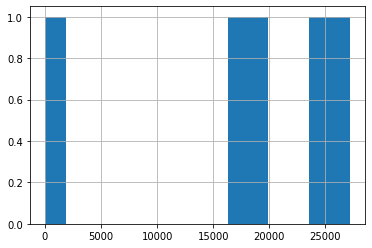

In [26]:
sample_df_3['count'].hist(bins=15)

Как видно из таблицы выше, наименьшее количество постов пользователей, зарегистрированных в сентябре 2008 года, было в августе 2008 года. Что может свидетельствовать либо о некорректных данных о дате регистрации/дате публикации поста, либо о том, что зарегистрированные пользователи оставляли посты до момента регистрации. 

# Задание 4

Используя данные о постах, выведите несколько полей:

- идентификатор пользователя, который написал пост;
- дата создания поста;
- количество просмотров у текущего поста;
- сумму просмотров постов автора с накоплением.

Данные в таблице должны быть отсортированы по возрастанию идентификаторов пользователей, а данные об одном и том же пользователе — по возрастанию даты создания поста.

| user_id | creation_date | views_count | cumulative_count |
| ------ | -------------- | ----------- | ---------------- |
| 1 | 2008-07-31 23:41:00  | 480476   | 480476  |
| 1 | 2008-07-31 23:55:38  | 136033 | 616509  | 
| 1 | 2008-07-31 23:56:41  | 0 |  616509  |
| ... | ... | ... | ... |
| 2 | 2008-07-31 23:56:41 | 79087  | 79087 |
| 2 | 2008-08-01 05:09:56 | 65443 | 144530 |
| ... | ...  | ...  | ...  |

In [27]:
# напишите запрос
query_4= '''
SELECT user_id,
           creation_date,
           views_count,
           SUM(views_count) OVER (PARTITION BY user_id ORDER BY creation_date ) AS cumulative_count
       
FROM stackoverflow.posts  
ORDER BY user_id, creation_date

'''

# выполните запрос

In [28]:
sample_df_4 = pd.read_sql_query(query_4, con=engine) 

In [29]:
sample_df_4

,user_id,creation_date,views_count,cumulative_count
0,1,2008-07-31 23:41:00,480476,480476
1,1,2008-07-31 23:55:38,136033,616509
2,1,2008-07-31 23:56:41,0,616509
3,1,2008-08-04 02:45:08,0,616509
4,1,2008-08-04 04:31:03,0,616509
...,...,...,...,...
243791,5696608,2008-12-23 16:00:37,0,2804
243792,5696608,2008-12-23 17:35:09,0,2804
243793,5696608,2008-12-24 01:02:48,0,2804
243794,5696608,2008-12-30 14:34:45,0,2804


# Задание 5

Найдите среднее количество постов пользователей в день за август 2008 года. Отберите данные о пользователях, которые опубликовали больше 120 постов за август. Дни без публикаций не учитывайте. 

Отсортируйте результат по возрастанию среднего количества постов. Значения можно не округлять.

| user_id | avg_daily |
| ------- | --------- |
| 116     | 4.777778  |
| 234     | 5.208333  |
| ...     | ... |

In [30]:
# напишите запрос
query_5 = '''

    WITH POSTS AS (WITH TOP_ID AS (
        WITH TBL AS (SELECT user_id id,
        count(*) as count
        FROM stackoverflow.posts
        WHERE creation_date BETWEEN '2008-08-01' AND '2008-09-01'
        GROUP BY user_id
        ORDER BY count DESC)

        SELECT id
        FROM TBL
        WHERE count>120
    )

    SELECT user_id AS id, 
           DATE_TRUNC('day', CAST(creation_date AS date)) AS day,
           count(id)
    FROM stackoverflow.posts
    WHERE creation_date BETWEEN '2008-08-01' AND '2008-09-01'
    AND user_id IN (SELECT * FROM TOP_ID)
    GROUP BY user_id, DATE_TRUNC('day', CAST(creation_date AS date))
    )
SELECT ID, AVG(count)
FROM POSTS
GROUP BY ID 

'''


# выполните запрос

In [31]:
sample_df_5 = pd.read_sql_query(query_5, con=engine) 


In [32]:
sample_df_5.head(15)

,id,avg
0,116,4.777778
1,905,7.000000
2,91,5.681818
3,383,7.277778
4,234,5.208333


# Задание 6

Сколько в среднем дней в период с 1 по 7 декабря 2008 года пользователи взаимодействовали с платформой? Для каждого пользователя отберите дни, в которые он или она опубликовали хотя бы один пост. Нужно получить одно целое число — не забудьте округлить результат. 

| result |
| -----  |
| <целое число> |

In [33]:
# напишите запрос
query_6 = '''
WITH t2 AS (
    with t1 AS (
    select user_id,
    DATE_TRUNC('day', creation_date)::date,
    COUNT(id)

    FROM stackoverflow.posts
    WHERE creation_date::date BETWEEN '2008-12-01' and '2008-12-07'
    GROUP BY user_id, DATE_TRUNC('day', creation_date)::date
    )

    SELECT user_id,
    COUNT(date_trunc) AS days_count
    FROM t1
    GROUP BY user_id
)

SELECT ROUND(AVG(days_count))
FROM t2
'''

# выполните запрос

In [34]:
sample_df_6 = pd.read_sql_query(query_6, con=engine) 

In [35]:
sample_df_6

,round
0,2.0


Проанализируйте итоговую таблицу — какие выводы можно сделать?

В первую неделю декабря 2008 года пользовтаели в среднем взаимодействовали с платформой 2 дня за неделю.

# Задание 7

Выведите историю активности каждого пользователя в таком виде: идентификатор пользователя, дата публикации поста. Отсортируйте вывод по возрастанию идентификаторов пользователей, а для каждого пользователя — по возрастанию даты публикации.

Добавьте в таблицу новое поле: для каждого поста в нём будет указано название месяца предпоследней публикации пользователя относительно текущей. Если такой публикации нет, укажите `NULL`.  Python автоматически поменяет `NULL` на `None`, но дополнительно преобразовывать значения `None` вам не нужно.

Посмотрите внимательно на образец таблицы: для первых двух постов предпоследней публикации нет, но, начиная с третьего поста, в новое поле входит нужный месяц. Для следующего пользователя в первые две записи поля `second_last_month` тоже войдёт `NULL`.

| user_id | creation_date | second_last_month |
| ------- | ------------- | ----------------- |
| 1       | 2008-07-31 23:41:00 | None |
| 1       | 2008-07-31 23:55:38 | None |
| 1       | 2008-07-31 23:56:41 | July |
| 1       | 2008-08-04 02:45:08 | July |
| 1       | 2008-08-04 04:31:03 | July |
| 1       | 2008-08-04 08:04:42 | August |
| ... | ... | ... |

In [37]:
# напишите запрос
query_7 = '''
WITH t1 AS (
    SELECT user_id,
        creation_date,
        LAG(extract(MONTH from creation_date), 2, NULL) OVER (PARTITION BY user_id ORDER BY creatioN_date) AS creation_date_lag         
    FROM stackoverflow.posts
)

SELECT user_id,
       creation_date,
       case
           when creation_date_lag = 1.0 then 'January'
           when creation_date_lag = 2.0 then 'Febrary'
           when creation_date_lag = 3.0 then 'March'
           when creation_date_lag = 4.0 then 'April'
           when creation_date_lag = 5.0 then 'May'
           when creation_date_lag = 6.0 then 'June'
           when creation_date_lag = 7.0 then 'July'
           when creation_date_lag = 8.0 then 'August'
           when creation_date_lag = 9.0 then 'September'
           when creation_date_lag = 10.0 then 'October'
           when creation_date_lag = 11.0 then 'November'
           when creation_date_lag = 12.0 then 'December'
           else 'None'
       END AS second_last_month
FROM t1       
'''

# выполните запрос

In [38]:
sample_df_7 = pd.read_sql_query(query_7, con=engine) 

In [39]:
sample_df_7

,user_id,creation_date,second_last_month
0,1,2008-07-31 23:41:00,None
1,1,2008-07-31 23:55:38,None
2,1,2008-07-31 23:56:41,July
3,1,2008-08-04 02:45:08,July
4,1,2008-08-04 04:31:03,July
...,...,...,...
243791,5696608,2008-12-23 16:00:37,December
243792,5696608,2008-12-23 17:35:09,December
243793,5696608,2008-12-24 01:02:48,December
243794,5696608,2008-12-30 14:34:45,December


# Задание 8

Рассчитайте аналог Retention Rate по месяцам для пользователей StackOverflow. Объедините пользователей в когорты по месяцу их первого поста. Возвращение определяйте по наличию поста в текущем месяце. 

| cohort_dt | session_date | users_cnt | cohort_users_cnt | retention_rate |
| --- | --- | --- | --- | --- |
| 2008-07-01 00:00:00 | 2008-07-01 00:00:00 | 3 | 3 | 100 |
| 2008-07-01 00:00:00 | 2008-08-01 00:00:00 | 2 | 3 | 66,67 |
| 2008-07-01 00:00:00 | 2008-09-01 00:00:00 | 1 | 3 | 33,33 |
| 2008-07-01 00:00:00 | 2008-10-01 00:00:00 | 2 | 3 | 66,67 |
| 2008-07-01 00:00:00 | 2008-11-01 00:00:00 | 1 | 3 | 33,33 |
| 2008-07-01 00:00:00 | 2008-12-01 00:00:00 | 2 | 3 | 66,67 |
| 2008-08-01 00:00:00 | 2008-08-01 00:00:00 | 2151 | 2151 | 100 |
| ... | ... | ... | ... | ... |

In [40]:
# напишите запрос
query_8 = '''
  WITH PROFILE AS
  (WITH t1 AS
     (SELECT DISTINCT user_id,
                      min(date_trunc('month', creation_date)) OVER (PARTITION BY user_id) AS first_post
      FROM stackoverflow.posts) 
      SELECT *,
                           count(*) OVER (PARTITION BY first_post) AS cohort_users_cnt
   FROM t1
   ORDER BY user_id),
   sessions AS
  (SELECT user_id,
          DATE_TRUNC('month', creation_date) AS session_date
   FROM stackoverflow.posts
   GROUP BY user_id,
            DATE_TRUNC('month', creation_date)
            )
            
            
SELECT first_post AS cohort_dt,
       session_date,
       COUNT(p.user_id) AS users_cnt,
       cohort_users_cnt,
       ROUND(COUNT(p.user_id) * 100.0 / cohort_users_cnt, 2) AS retention_rate
FROM PROFILE AS p
INNER JOIN sessions AS s ON p.user_id = s.user_id
GROUP BY 1,
         2,
         4
'''
# выполните запрос

In [41]:
sample_df_8= pd.read_sql_query(query_8, con=engine) 

In [42]:
sample_df_8

,cohort_dt,session_date,users_cnt,cohort_users_cnt,retention_rate
0,2008-07-01,2008-07-01,3,3,100.00
1,2008-07-01,2008-08-01,2,3,66.67
2,2008-07-01,2008-09-01,1,3,33.33
3,2008-07-01,2008-10-01,2,3,66.67
4,2008-07-01,2008-11-01,1,3,33.33
5,2008-07-01,2008-12-01,2,3,66.67
6,2008-08-01,2008-08-01,2151,2151,100.00
7,2008-08-01,2008-09-01,1571,2151,73.04
8,2008-08-01,2008-10-01,1275,2151,59.27
9,2008-08-01,2008-11-01,1050,2151,48.81


Постройте тепловую карту Retention Rate. Какие аномалии или другие необычные явления удалось выявить? Сформулируйте гипотезы о возможных причинах.

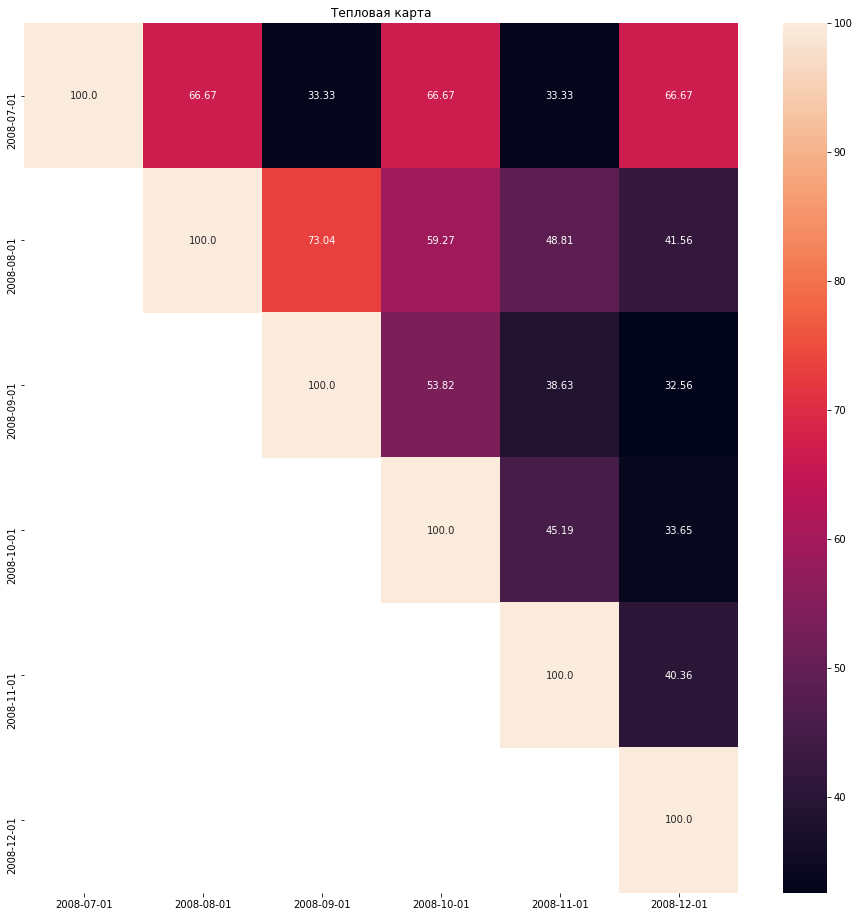

In [43]:
# постройте тепловую карту Retention Rate
# создаём сводную таблицу с результатами
retention = sample_df_8.pivot('cohort_dt', 'session_date', 'retention_rate')
retention.index = [str(x)[0:10] for x in retention.index]
retention.columns = [str(x)[0:10] for x in retention.columns]

# строим хитмэп
plt.figure(figsize=(16, 16)) # задаём размер графика
sns.heatmap(retention, # датафрейм с данными
            annot=True, # добавляем подписи
            fmt='') # задаём исходный формат
plt.title('Тепловая карта') # название графика
plt.show() 

1. В когорте пользователей, пришедших с июля по сентябрь 2008 года коэффициент удержания первого месяца больше 50%.
2. Количество пользователей, пришедших в июле 2008 года, во 2-м и 4-м месяце после регистрации существенно снидалось,
при этом, в 3-м и 5-м месяцах, количество пользователей восстанавливалось. Возможно это связано с тем,
что пользователи удалялись и восстанавливались вновь.
3. В когорте пришедших в ноябре 2008 года, самое маленькое значение Retention Rate за первый месяц.

# Задание 9


На сколько процентов менялось количество постов ежемесячно с 1 сентября по 31 декабря 2008 года? Отобразите таблицу со следующими полями:

- номер месяца;
- количество постов за месяц;
- процент, который показывает, насколько изменилось количество постов в текущем месяце по сравнению с предыдущим.

Если постов стало меньше, значение процента должно быть отрицательным, если больше — положительным. Округлите значение процента до двух знаков после запятой.

Напомним, что при делении одного целого числа на другое в PostgreSQL в результате получится целое число, округлённое до ближайшего целого вниз. Чтобы этого избежать, переведите делимое в тип `numeric`.

| creation_month | posts_count | percentage |
| -------------- | ----------- | ---------- |
| 9 | 70731 | Nan |
| 10 | 63102 | -10.33 |
| ... | ... | ... |

In [45]:
# напишите запрос
query_9 = '''
WITH t1 AS (
    SELECT DISTINCT
        EXTRACT(month FROM creation_date)::int AS creation_month,
        COUNT(*) OVER (PARTITION BY EXTRACT(month FROM creation_date)) AS posts_count
    FROM stackoverflow.posts
    WHERE creation_date >= '01.09.2008'
      AND creation_date <= '31.12.2008'
)

SELECT
     creation_month,
     posts_count,
     ROUND( ((posts_count::float - LAG(posts_count) OVER (ORDER BY creation_month)) /
                                                         LAG(posts_count) OVER (ORDER BY creation_month) * 100)::numeric, 2)
FROM t1     
'''

# выполните запрос

In [46]:
sample_df_9 = pd.read_sql_query(query_9, con=engine) 

In [47]:
sample_df_9

,creation_month,posts_count,round
0,9,70371,NaN
1,10,63102,-10.33
2,11,46975,-25.56
3,12,44592,-5.07


Постройте круговую диаграмму с количеством постов по месяцам.

(-1.1113450333821802,
 1.1005402602007526,
 -1.1194443395301965,
 1.1127112873136231)

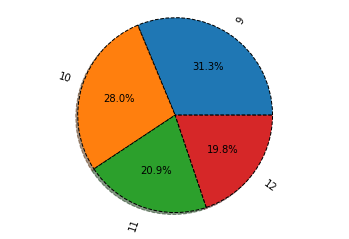

In [48]:
# постройте круговую диаграмму с количеством постов по месяцам
fig, ax = plt.subplots()
ax.pie(sample_df_9['posts_count'], labels=sample_df_9['creation_month'], autopct='%1.1f%%', shadow=True,
        wedgeprops={'lw':1, 'ls':'--', 'edgecolor':'k'}, rotatelabels=True)
ax.axis('equal')

# Задание 10

Выгрузите данные активности пользователя, который опубликовал больше всего постов за всё время. Выведите данные за октябрь 2008 года в таком виде:

- номер недели;
- дата и время последнего поста, опубликованного на этой неделе.

| week_creation | creation_date |
| ------------- | ------------- |
| 40 | 2008-10-05 09:00:58 |
| 41 | 2008-10-12 21:22:23 |
| ... | ... |

In [49]:
# напишите запрос
query_10 = '''
WITH t1 AS (
    SELECT user_id AS top_user,
        COUNT(*) AS post_count 
    FROM stackoverflow.posts
    GROUP BY user_id
    ORDER BY post_count DESC
    LIMIT 1   
)

SELECT
    EXTRACT(week FROM creation_date)::int AS week_creation,
    MAX(creation_date) AS creation_date
FROM stackoverflow.posts
WHERE user_id = (SELECT top_user FROM t1) AND
      creation_date >= '01-10-2008' AND
      creation_date <= '01-11-2008'
GROUP BY EXTRACT(week FROM creation_date)

'''

# выполните запрос

In [50]:
sample_df_10 = pd.read_sql_query(query_10, con=engine) 

In [51]:
sample_df_10

,week_creation,creation_date
0,40,2008-10-05 09:00:58
1,41,2008-10-12 21:22:23
2,42,2008-10-19 06:49:30
3,43,2008-10-26 21:44:36
4,44,2008-10-31 22:16:01
